# Model Error Analysis - Tutorial

Install the [Model Error Analysis plugin](https://www.dataiku.com/product/plugins/model-error-analysis/) and import the required libraries.

In [1]:
import dataiku

In [2]:
dataiku.use_plugin_libs('model-error-analysis')

In [3]:
from dku_error_analysis_mpp.dku_error_visualizer import DkuErrorVisualizer
from dku_error_analysis_mpp.dku_error_analyzer import DkuErrorAnalyzer
from dku_error_analysis_model_parser.model_handler_utils import get_model_handler

Error Analysis Plugin | WARNING - Cloudpickle is not installed on this code env. Falling back on pickle.


In [4]:
%matplotlib inline

## Load a trained primary model

Load any trained DSS classification or regression model. This is your _Primary Model_.

Replace the `lookup` and `version_id` placeholders with your own model identifiers.

In [5]:
lookup='model_price'
version_id='initial'

Build an accessor to your model through `get_model_handler`.

In [0]:
m = dataiku.Model(lookup)
model_handler = get_model_handler(m, version_id)

## Use a DkuErrorAnalyzer

Instantiate a `DkuErrorAnalyzer` object with your model accessor.

In [7]:
dku_error_analyzer = DkuErrorAnalyzer(model_handler)

Fit the underlying <font color=red>_Error Tree_ </font> to your DSS model performances on its test set.

In [8]:
dku_error_analyzer.fit()

Error Analysis Plugin | INFO - Reading with dtypes: None
Error Analysis Plugin | INFO - Computed dtype for id: None (schema_type=string feature_type=CATEGORY feature_role=REJECT)
Error Analysis Plugin | INFO - Computed dtype for date: str (schema_type=string feature_type=CATEGORY feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for price: <class 'numpy.float64'> (schema_type=double feature_type=NUMERIC feature_role=TARGET)
Error Analysis Plugin | INFO - Computed dtype for bedrooms: <class 'numpy.float64'> (schema_type=bigint feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for bathrooms: <class 'numpy.float64'> (schema_type=double feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for sqft_living: <class 'numpy.float64'> (schema_type=bigint feature_type=NUMERIC feature_role=INPUT)
Error Analysis Plugin | INFO - Computed dtype for sqft_lot: <class 'numpy.float64'> (schema_type=bigint feature_type=

Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (floors)
Error Analysis Plugin | DEBUG -   Rescale floors (avg=1.490938661710037 std=0.5365226188355177 shift=1.4951470333352592 inv_scale=1.8489089245704837)
Error Analysis Plugin | DEBUG -   Rescaled floors (avg=-0.00778089585578228 std=0.9919814581989164) nulls=0
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (sqft_lot)
Error Analysis Plugin | DEBUG -   Rescale sqft_lot (avg=14207.940752788105 std=34601.95474189959 shift=15330.516667629558 inv_scale=2.328492871431231e-05)
Error Analysis Plugin | DEBUG -   Rescaled sqft_lot (avg=-0.026139100153487173 std=0.8057040495409928) nulls=0
Error Analysis Plugin | DEBUG - PROCESS WITH Step:RescalingProcessor2 (lat)
Error Analysis Plugin | DEBUG -   Rescale lat (avg=47.5586906366171 std=0.13926283675920403 shift=47.56039116066808 inv_scale=7.225888953087066)
Error Analysis Plugin | DEBUG -   Rescaled lat (avg=-0.012287797954450461 std=1.006297793713899

### Error Tree

The underlying Error Tree can be retrieved by the attribute `_error_tree`.

You can see that its estimator consists in a `DecisionTree` from `sklearn` predicting _Correct_ or _Wrong Prediction_.

In [10]:
error_clf = dku_error_analyzer._error_tree._estimator
print(error_clf)
print(error_clf.classes_)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=65537, splitter='best')
['Correct prediction' 'Wrong prediction']


The features used in the Error Tree can be retrieved by the attribute `feature_names`. 

These features are the very same used by your primary model.

In [11]:
feature_names = dku_error_analyzer.feature_names
feature_names[:3]

['bathrooms', 'sqft_above', 'sqft_lot15']

### Error Tree Metrics

You can have a report on the Error Tree thanks to the `evaluate` function as a text or formatted output. 

This will output some metrics computed on a part of the test set of your DSS model:
1. the Error Tree accuracy score
2. the estimated accuracy of your primary model according to the Error Tree
3. the true accuracy of your primary model
4. the _Fidelity_ of the Error Tree (absolute deviation of 2. and 3.)

Ideally the two values 2. and 3. above should be equal, thus their deviation (_Fidelity_) is computed as an indicator of how well the Error Tree represents your model performances.

The _Confidence Decision_ states whether you can trust the Error Tree as a representation of your model performances.

In [16]:
print(dku_error_analyzer.evaluate(output_format='str'))

Error Analysis Plugin | INFO - Prepare data with model for model performance predictor


The MPP was trained with accuracy 93.61%.
The Decision Tree estimated the primary models accuracy to 96.52%.
The true accuracy of the primary model is 91.99.%
The Fidelity of the MPP is 95.47%.
The MPP is considered representative of the primary model performances.



In [17]:
dku_error_analyzer.evaluate(output_format='dict')

Error Analysis Plugin | INFO - Prepare data with model for model performance predictor


{'mpp_accuracy_score': 0.9361207897793263,
 'primary_model_true_accuracy': 0.9198606271777003,
 'primary_model_predicted_accuracy': 0.9651567944250871,
 'confidence_decision': True}

## Use a DkuErrorVisualizer

Instantiate a `DkuErrorVisualizer` object on your `DkuErrorAnalyzer` object in order to have useful plot and analysis functions.

In [18]:
dku_error_visualizer = DkuErrorVisualizer(dku_error_analyzer)

### Plot the Decision Tree

Plot the Error Tree decision tree and have a look at the red nodes, representing your primary model failures.

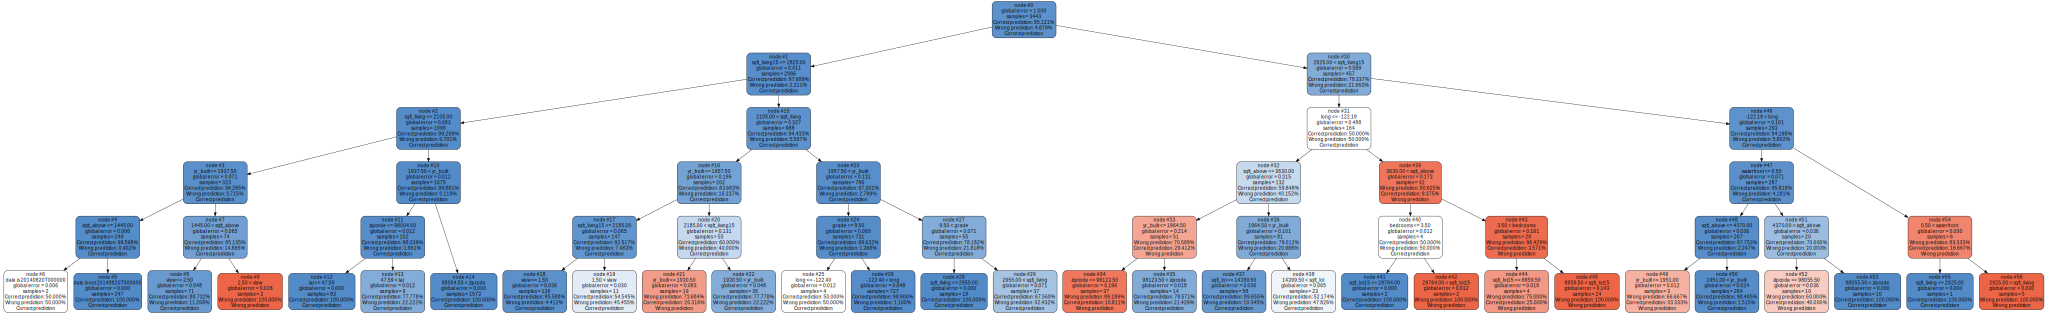

In [19]:
dku_error_visualizer.plot_error_tree(size=(25, 25))

### Explore the Error Tree nodes

Use the `get_error_leaf_summary` function of the `DkuErrorAnalyzer` to explore the nodes and have information about the samples they contain. 

The provided information covers:
1. the number of correct predictions,
2. the number of wrong predictions,
3. the node _Local error_: the ratio of the number of wrongly predicted samples over the total number of samples in the node. This is the error rate in the node. It is interesting to focus on nodes where the local error rate is higher than the average error rate of the model on all samples. 
4. the node _Global error_: the ratio of the number of wrongly predicted samples over the total number of mispredicted samples in the test set. The nodes where the global erro is high is where the majority of wrong predictions are located.
5. the path to node: showing roughly the features behaviour for the samples in the node. Helps understanding what feature ranges are contributing the most to the error. 

The different nodes contain meaningful segments of the test set, and represent different types of errors the primary model makes.

We are especially interested in nodes with high Global Error (majority of errors) and high Local Error (the error rate in the subgroup of samples in the node). Especially if the local error is much higher than the average error rate of the model.

You can input leaf nodes from the tree plot above (`leaf_selector` argument).

Replace `leaf_id` with the leaf node you would like to explore. 

In [20]:
leaf_id = 8

In [21]:
dku_error_analyzer.get_error_leaf_summary(leaf_selector=leaf_id, add_path_to_leaves=True, output_format='str')

LEAF 8:
     Correct predictions: 63 | Wrong predictions: 8 | Local error (purity): 0.11 | Global error: 0.05
     Path to leaf:
     sqft_living15 <= 2825.00
        sqft_living <= 2105.00
           yr_built <= 1937.50
              1445.00 < sqft_above
                 view <= 2.50


You can also let the analyzer show you all the leaf nodes ranked by importance (higher global error).

In [22]:
dku_error_analyzer.get_error_leaf_summary(add_path_to_leaves=True, output_format='str')

LEAF 34:
     Correct predictions: 4 | Wrong predictions: 33 | Local error (purity): 0.89 | Global error: 0.20
     Path to leaf:
     2825.00 < sqft_living15
        long <= -122.19
           sqft_above <= 3630.00
              yr_built <= 1964.50
                 zipcode <= 98123.50
LEAF 45:
     Correct predictions: 0 | Wrong predictions: 24 | Local error (purity): 1.00 | Global error: 0.14
     Path to leaf:
     2825.00 < sqft_living15
        long <= -122.19
           3630.00 < sqft_above
              3.50 < bedrooms
                 8859.50 < sqft_lot15
LEAF 56:
     Correct predictions: 0 | Wrong predictions: 5 | Local error (purity): 1.00 | Global error: 0.03
     Path to leaf:
     2825.00 < sqft_living15
        -122.19 < long
           0.50 < waterfront
              2925.00 < sqft_living
LEAF 9:
     Correct predictions: 0 | Wrong predictions: 3 | Local error (purity): 1.00 | Global error: 0.02
     Path to leaf:
     sqft_living15 <= 2825.00
        sqft_living <= 210

### Display the Feature Distributions of samples in the nodes

You can use the `DkuErrorVisualizer` to plot the histograms of the features in the nodes, comparing to the global population as it is a mainly successful baseline.

Again, you can either input leaf nodes by the `leaf_selector` argument.

Leaf 8 (Correct prediction: 0.887, Wrong prediction: 0.113)


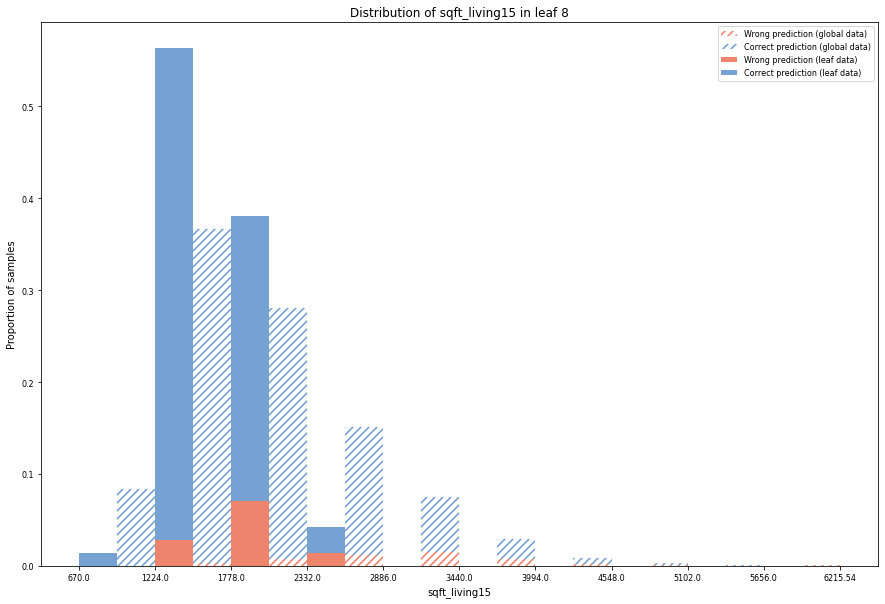

Leaf 8 (Correct prediction: 0.887, Wrong prediction: 0.113)


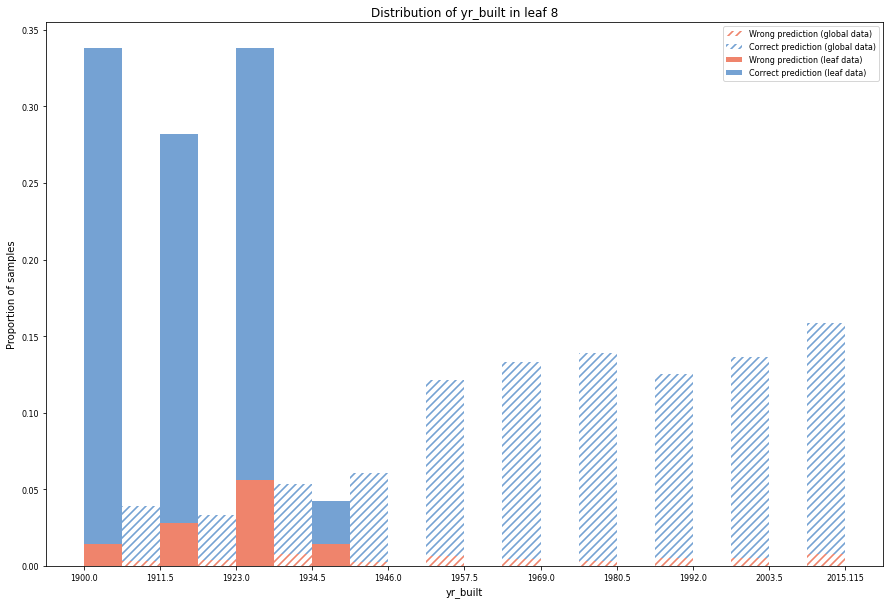

Leaf 8 (Correct prediction: 0.887, Wrong prediction: 0.113)


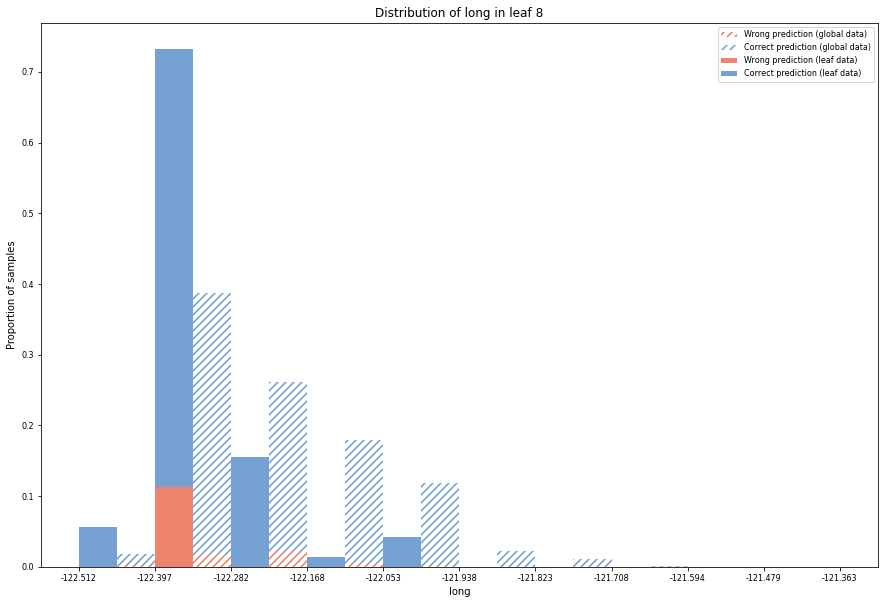

In [25]:
dku_error_visualizer.plot_feature_distributions_on_leaves(leaf_selector=leaf_id, top_k_features=3, show_class=True, show_global=True)


You can also let the visualizer show you the feature distributions in all the leaf nodes ranked by importance.

Leaf 34 (Wrong prediction: 0.892, Correct prediction: 0.108)


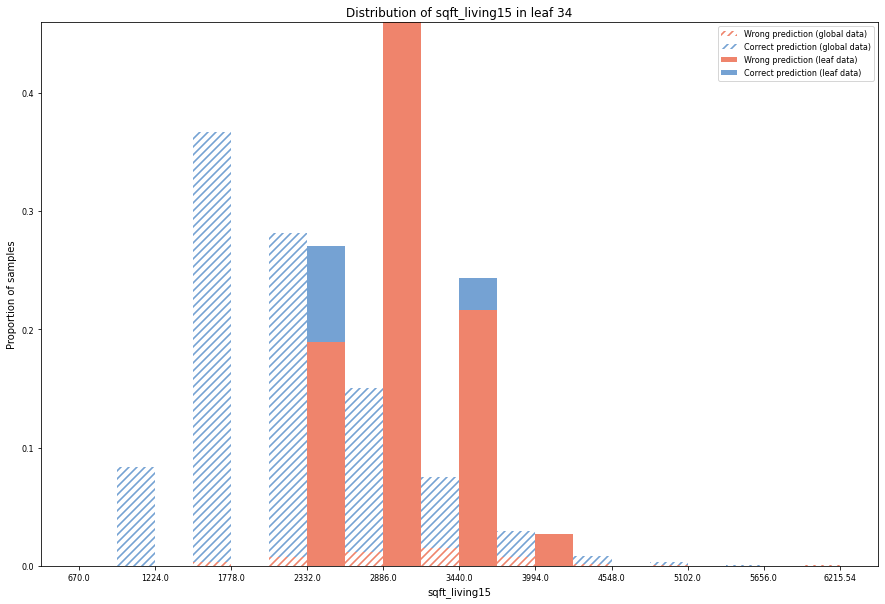

Leaf 45 (Wrong prediction: 1.000)


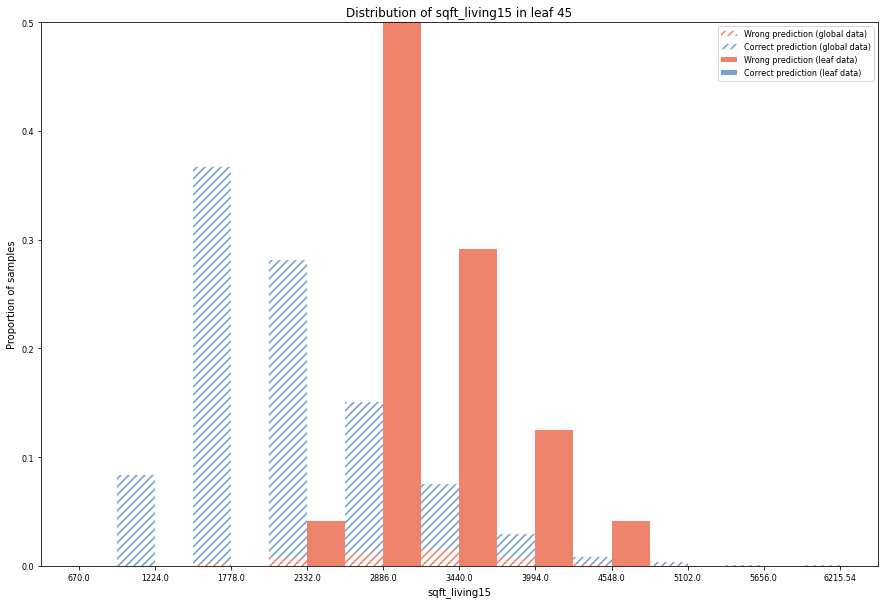

Leaf 56 (Wrong prediction: 1.000)


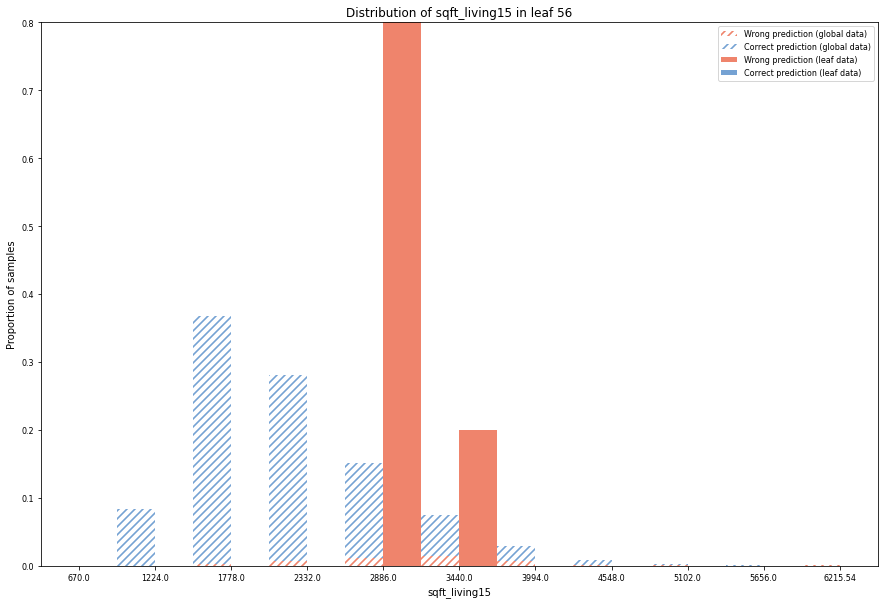

Leaf 9 (Wrong prediction: 1.000)


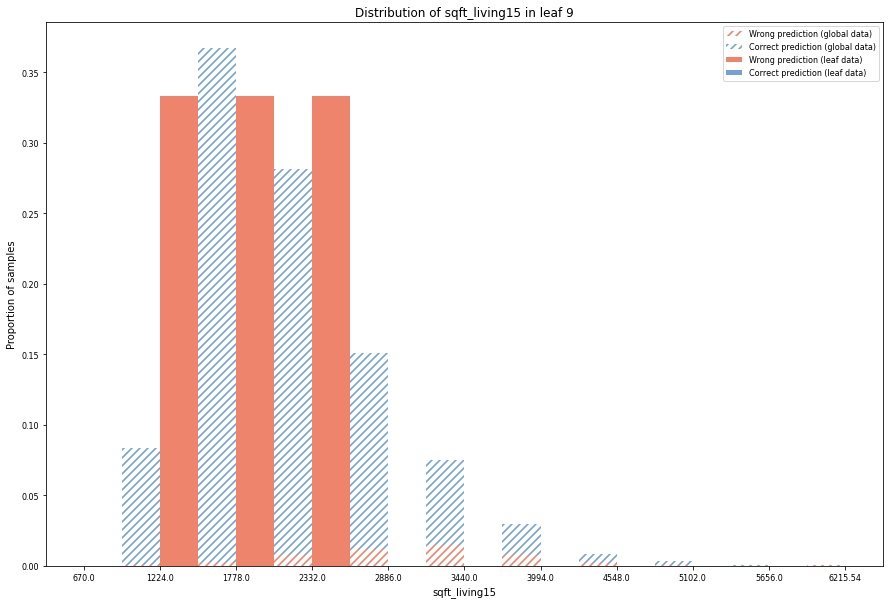

Leaf 42 (Wrong prediction: 1.000)


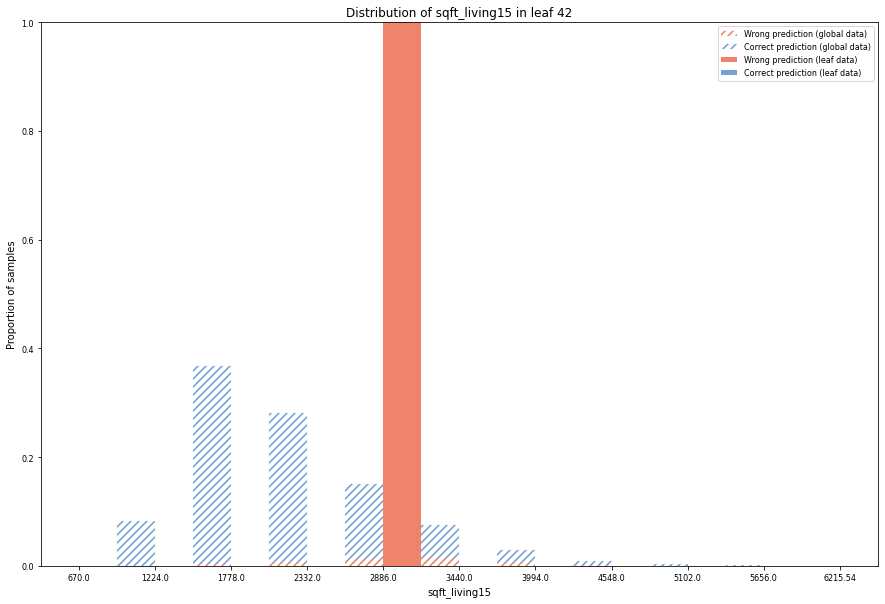

Leaf 21 (Wrong prediction: 0.737, Correct prediction: 0.263)


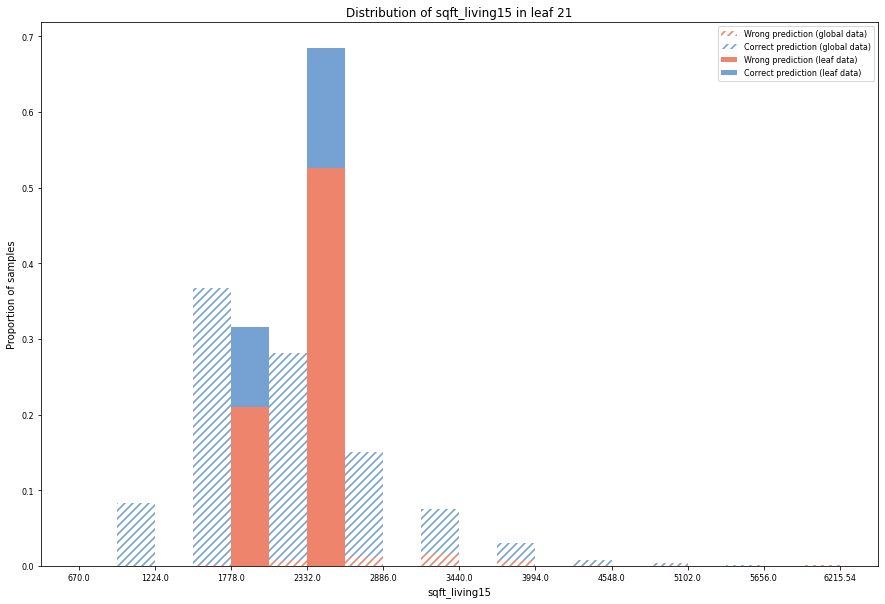

Leaf 44 (Wrong prediction: 0.750, Correct prediction: 0.250)


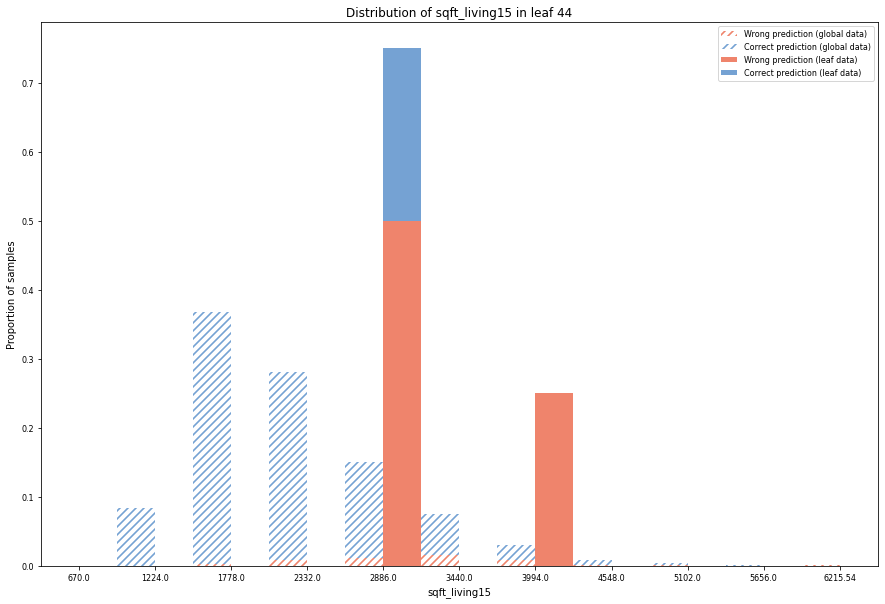

Leaf 52 (Wrong prediction: 0.600, Correct prediction: 0.400)


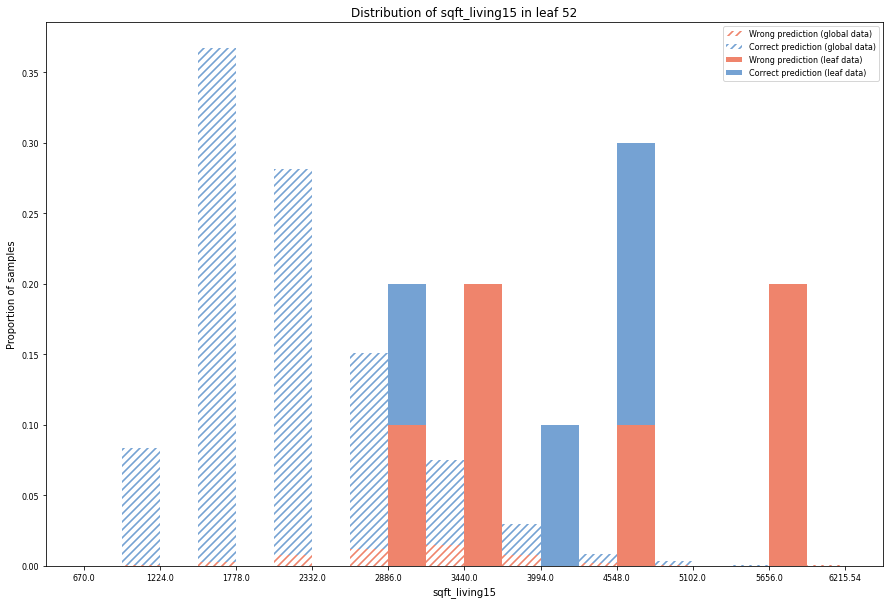

Leaf 49 (Wrong prediction: 0.667, Correct prediction: 0.333)


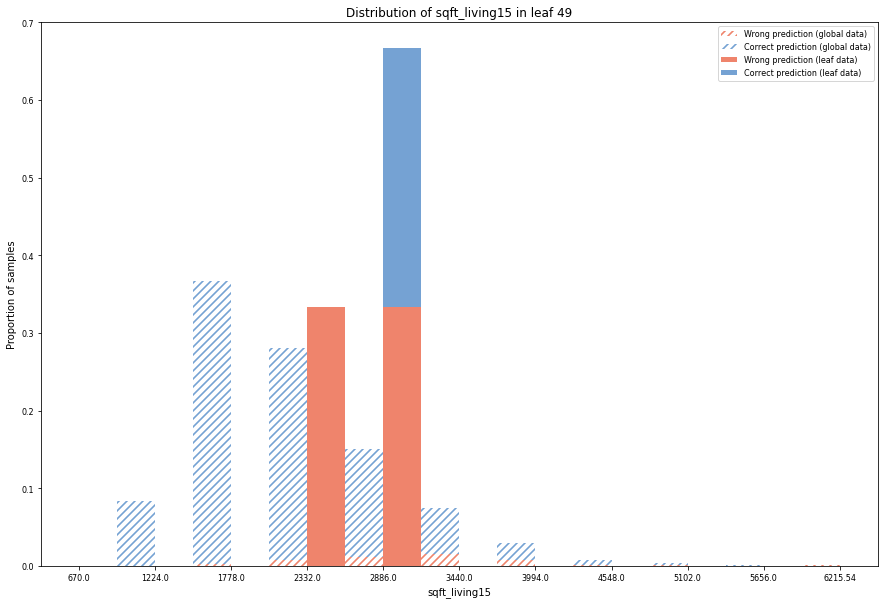

In [27]:
dku_error_visualizer.plot_feature_distributions_on_leaves(top_k_features=1, show_class=True)

In this example we observe that the primary model yields wrong predictions for houses with very large living rooms and high scored views. Comparing with the global baseline, we see that these samples are under-represented in the primary training set. 

# Moving forward

The Model Error Analysis plugin automatically highlights any information relevant to the model errors, leading the user to focus on what are the problematic features and what are the typical values of these features for the mispredicted samples.

This information can later be exploited to support the strategy selected by the user :
* **improve model design**: removing a problematic feature, removing samples likely to be mislabeled, ensemble with a model trained on a problematic subpopulation, ...
* **enhance data collection**: gather more data regarding the most erroneous under-represented populations,
* **select critical samples for manual inspection** thanks to the Error Tree and avoid primary predictions on them, generating model assertions.